## Hand Sign Recognition

The Sign Language MNIST dataset is presented here and follows the jpeg image format with labels . The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

There are a total of 27,455 gray-scale images of size 28*28 pixels whose value range between 0-255. Each case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions).

In [1]:
!pip install torchinfo

In [2]:
!pip install transformers

In [3]:
!pip install numpy matplotlib tqdm pillow torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from sklearn.metrics import classification_report

import zipfile
from pathlib import Path
import os
import random
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
data_path = Path("data")
image_path = data_path / "images"

if image_path.is_dir():
  print(f"{image_path} already exists")
else:
  print(f"{image_path} does not exist yet")
  image_path.mkdir(parents=True, exist_ok=True)


with zipfile.ZipFile("archive.zip", "r") as zip:
  zip.extractall(image_path)


data/images does not exist yet


In [6]:
train_dir = image_path / "Train"
test_dir = image_path/ "Test"

#### Visualizing the data

Here we are visualizing the data at random

image shape: (28, 28)
image path: data/images/Train/R/22457_R.jpg
image class: R
height: 28 | width: 28
shape: (28, 28)


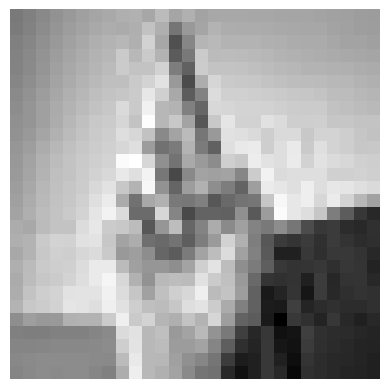

In [79]:
# getting the image paths
image_path_list = list(image_path.glob("Train/*/*.jpg"))
rand_image = random.choice(image_path_list)


rand_image.parent.stem # getting the class of the image

# open the image
img = Image.open(rand_image)
print(f"image shape: {img.size}")
print(f"image path: {rand_image}")
print(f"image class: {rand_image.parent.stem}")
print(f"height: {img.height} | width: {img.width}")

img_array = np.array(img)
print(f"shape: {img_array.shape}")
plt.imshow(img_array, cmap="gray")
plt.axis("off")
plt.show()

#### Loading the dataset into tensors with `ImageFolder` and applying data augmentation

Here, we are using the `ImageFolder` function provided by PyTorch to get he images into tensors. But we would also ned to transform them first.

- Turn themto tensors
- Normalize them
- Convert the images to grayscale so that Pytorch es the as 1 channel and not 3 channels

In [8]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
    transforms.Grayscale() # Grayscale ensures that pytorch sees it as 1 channel instead of 3 channels
    #transforms.Resize((224,224)),

])

In [9]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data
#train_data.samples

(Dataset ImageFolder
     Number of datapoints: 27455
     Root location: data/images/Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
                Grayscale(num_output_channels=1)
            ),
 Dataset ImageFolder
     Number of datapoints: 7172
     Root location: data/images/Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
                Grayscale(num_output_channels=1)
            ))

torch.Size([1, 28, 28])


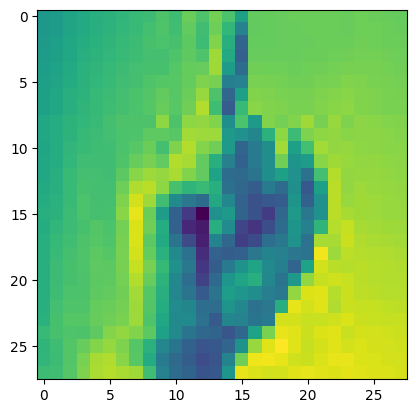

In [10]:
trans = data_transform(img)
print(trans.shape)
plt.imshow(trans.permute(1,2,0))

In [11]:
val_ratio = 0.2
num_train = len(train_data)
num_val = int(num_train * val_ratio)
num_train = num_train - num_val



torch.Size([1, 28, 28])


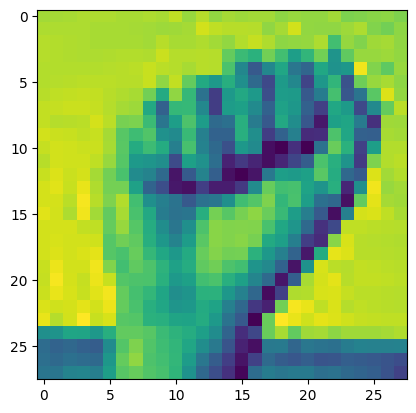

In [12]:
train_data, val_data = torch.utils.data.random_split(train_data, [num_train, num_val])
print(train_data.dataset[0][0].shape)
plt.imshow(train_data.dataset[0][0].permute(1,2,0))

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=24, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=24, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=False)

In [14]:
iter_img, label = next(iter(train_loader))
iter_img.shape, label.shape

(torch.Size([24, 1, 28, 28]), torch.Size([24]))

### Creating the Model

In [54]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        # Flatten size based on your debug output
        self.flatten_size = 32 * 4 * 4  # 32 channels, each of size 4x4

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 24)  # 24 is the number of classes
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x


In [55]:
model0 = BaselineNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=0.001)
image, label = next(iter(train_loader))
image.shape, label.shape

(torch.Size([24, 1, 28, 28]), torch.Size([24]))

In [56]:
summary(model0, input_size=(24, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BaselineNet                              [24, 24]                  --
├─Sequential: 1-1                        [24, 16, 12, 12]          --
│    └─Conv2d: 2-1                       [24, 8, 26, 26]           80
│    └─BatchNorm2d: 2-2                  [24, 8, 26, 26]           16
│    └─ReLU: 2-3                         [24, 8, 26, 26]           --
│    └─Conv2d: 2-4                       [24, 16, 24, 24]          1,168
│    └─BatchNorm2d: 2-5                  [24, 16, 24, 24]          32
│    └─ReLU: 2-6                         [24, 16, 24, 24]          --
│    └─MaxPool2d: 2-7                    [24, 16, 12, 12]          --
├─Sequential: 1-2                        [24, 64, 8, 8]            --
│    └─Conv2d: 2-8                       [24, 32, 10, 10]          4,640
│    └─BatchNorm2d: 2-9                  [24, 32, 10, 10]          64
│    └─ReLU: 2-10                        [24, 32, 10, 10]          --
│    └─Co

In [57]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_true)) * 100
  return acc

In [58]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn, optimizer, accuracy, device=device):

  model.train()
  train_loss = 0
  train_acc = 0
  for batch, (image, label) in enumerate(dataloader):

    image, label = image.to(device), label.to(device)
    # forward pass
    y_pred = model(image)

    loss = loss_fn(y_pred, label)
    train_loss += loss.item() # accumulate the training loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc += accuracy(y_true=label, y_pred=torch.argmax(y_pred, dim=1)) # accumulate the accuracy
  # Calculates the loss and accuracy. Make sure they are outside the loop
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return loss.item(), train_acc



In [59]:
def test_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn, accuracy, device=device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.no_grad():
    for batch, (image, label) in enumerate(dataloader):
      image, label = image.to(device), label.to(device)
      y_pred = model(image)
      #y_pred = y_pred.logits # for the sake of the pretrained model
      loss = loss_fn(y_pred, label) # calculate the loss
      test_loss += loss.item()
      test_acc += accuracy(y_true=label, y_pred=y_pred.argmax(dim=1))

      #y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      #test_acc += (y_pred_class==label).sum().item()

  # Calculates the loss and accuracy. Make sure they are outside the loop
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return loss.item(), test_acc

In [60]:
def train_test(model: nn.Module,
               train_loader: torch.utils.data.DataLoader,
               test_loader: torch.utils.data.DataLoader,
               loss_fn, opt, epochs, device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model.to(device), train_loader, loss_fn, opt, accuracy_fn)
    test_loss, test_acc = test_step(model.to(device), test_loader, loss_fn, accuracy_fn)
    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {test_loss:.4f} | Val Acc: {test_acc:.4f}")


    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results


In [61]:
results = train_test(model0, train_loader, val_loader, loss_fn=loss_fn, opt=optimizer, epochs=2)

 50%|█████     | 1/2 [00:35<00:35, 35.30s/it]

Epoch: 1 | Train Loss: 0.0121 | Train Acc: 94.0684 | Val Loss: 0.0023 | Val Acc: 100.0000


100%|██████████| 2/2 [01:10<00:00, 35.35s/it]

Epoch: 2 | Train Loss: 0.0026 | Train Acc: 100.0000 | Val Loss: 0.0004 | Val Acc: 100.0000


In [62]:
results

{'train_loss': [0.01206245832145214, 0.0025545917451381683],
 'train_acc': [94.06841339155748, 100.0],
 'test_loss': [0.0023005898110568523, 0.00037243595579639077],
 'test_acc': [100.0, 100.0]}

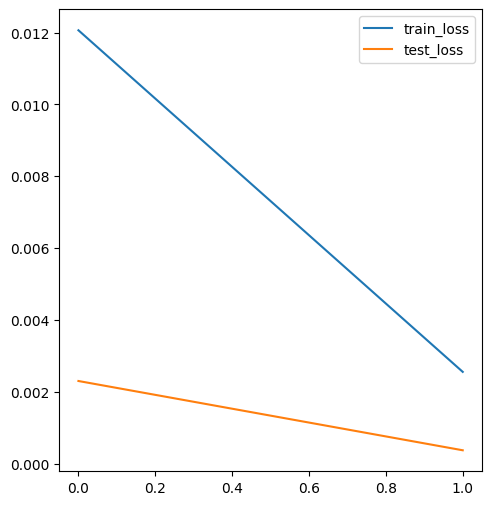

In [63]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(results["train_loss"], label="train_loss")
plt.plot(results["test_loss"], label="test_loss")
plt.legend()

And surprise, surprise, we get 100% accuracy on the validation set after 2 epochs. But there's predictions to be made on the test set

### Making predictions

In this case, we are taking 16 random samples from the test data and we want to predict them and visualize the results

In [64]:
test_samples = []
test_labels = []

for samples, labels in random.sample(list(test_data), k=16):
  samples = samples * np.array(1) + np.array(1)
  test_samples.append(samples)
  test_labels.append(labels)

In [65]:
def make_predictions(model: nn.Module,
                    data: list,
                    device: torch.device=device):
  preds = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      y_pred = model(sample) # forward pass
      pred = torch.softmax(y_pred.squeeze(), dim=0)

      preds.append(pred.cpu())

  return torch.stack(preds)



In [66]:
tens = make_predictions(model0, test_samples).argmax(dim=1)

In [67]:
tens

tensor([ 3, 13,  9,  6,  9,  1, 11,  1,  4,  4, 19, 17,  8,  8, 14, 18])

(-0.5, 27.5, 27.5, -0.5)

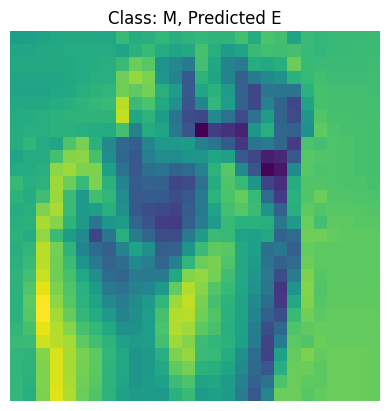

In [68]:
num = random.randint(0, len(test_samples)-1)
plt.imshow(test_samples[num].squeeze())
plt.title(f"Class: {test_data.classes[test_labels[num]]}, Predicted {test_data.classes[make_predictions(model0, [test_samples[num]]).argmax(dim=1).item()]}")
plt.axis("off")

### Visualizing the predictions

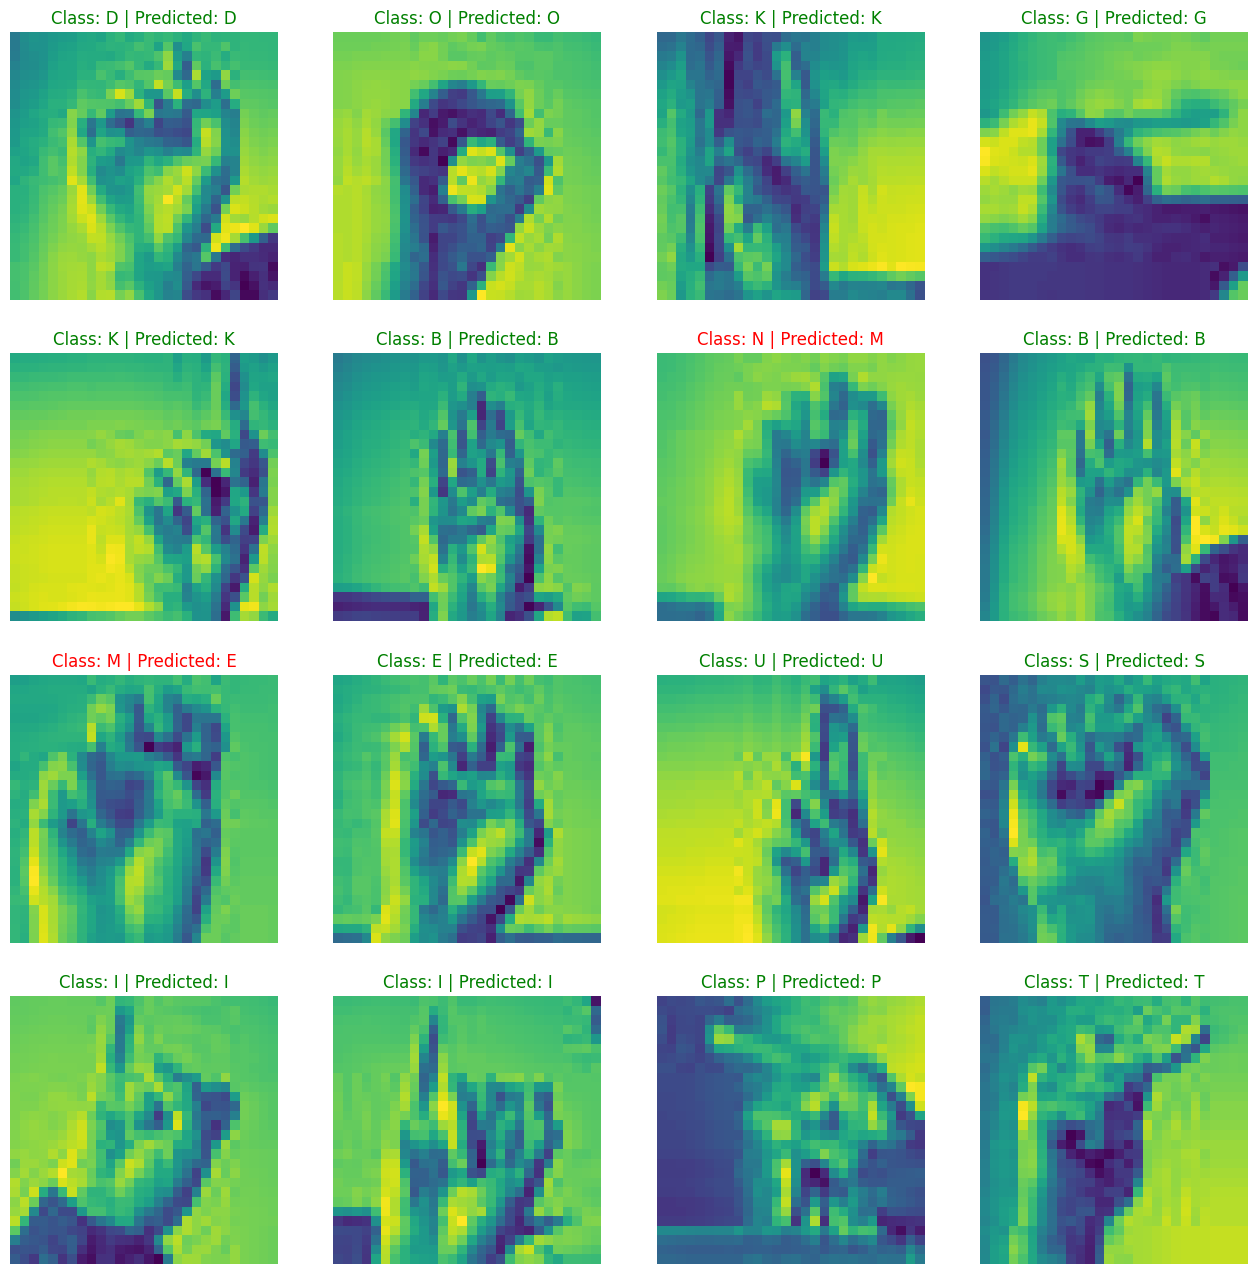

In [69]:
fig = plt.figure(figsize=(16,16))
nrows = 4
ncols = 4
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze())
  plt.axis("off")
  actual = test_data.classes[test_labels[i]]
  predicted = test_data.classes[make_predictions(model0, [test_samples[i]]).argmax(dim=1)]
  text = f"Class: {actual} | Predicted: {predicted}"
  if actual == predicted:
    plt.title(text, color="green")
  else:
    plt.title(text, color="red")



In [70]:
test_samples_full = []
test_labels_full = []

for samples, labels in test_data:
  samples = samples * np.array(1) + np.array(1)
  test_samples_full.append(samples)
  test_labels_full.append(labels)

In [71]:
y_pred_tensors = make_predictions(model0, test_samples_full).argmax(dim=1)

### Ploting a confusion matrix

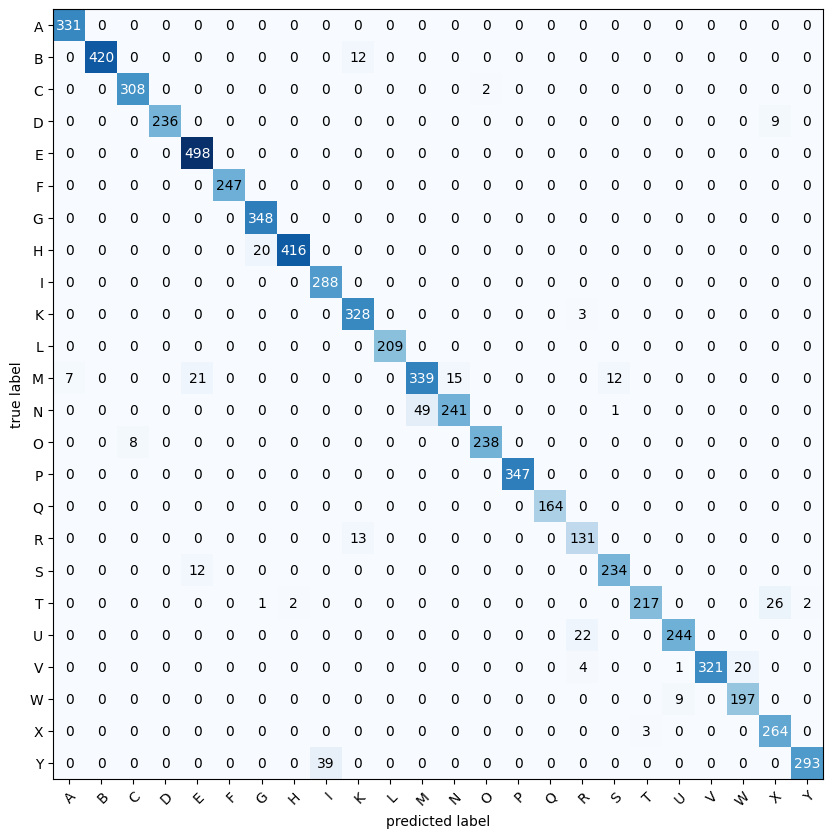

In [72]:
from mlxtend.plotting import plot_confusion_matrix
cm = ConfusionMatrix(num_classes = len(test_data.classes), task="multiclass") # it has to be multiclass
cm_tensor = cm(preds=y_pred_tensors, target = torch.Tensor(test_data.targets)) # it has to have the target attribute as a tensor

fig, ax = plot_confusion_matrix(conf_mat=cm_tensor.numpy(),
                                class_names=test_data.classes,
                                 figsize=(10, 10),)

### Generating a Classification report

In [73]:
report = classification_report(y_true=test_data.targets, y_pred=y_pred_tensors, target_names=test_data.classes)

In [74]:
print(report)

              precision    recall  f1-score   support

           A       0.98      1.00      0.99       331
           B       1.00      0.97      0.99       432
           C       0.97      0.99      0.98       310
           D       1.00      0.96      0.98       245
           E       0.94      1.00      0.97       498
           F       1.00      1.00      1.00       247
           G       0.94      1.00      0.97       348
           H       1.00      0.95      0.97       436
           I       0.88      1.00      0.94       288
           K       0.93      0.99      0.96       331
           L       1.00      1.00      1.00       209
           M       0.87      0.86      0.87       394
           N       0.94      0.83      0.88       291
           O       0.99      0.97      0.98       246
           P       1.00      1.00      1.00       347
           Q       1.00      1.00      1.00       164
           R       0.82      0.91      0.86       144
           S       0.95    